In [197]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt


class Node:
    def __init__(self, idx: int = None, origin: bool = False):
        self._idx = idx
        self._origin = origin  # Origin of the bar (0 or 1)

        # Coordinates of the node (m)
        self._x = 0.0 if origin else None
        self._y = 0.0 if origin else None

        # Force applied to the node (N)
        self._fx = 0.0  # Force in x direction (N)
        self._fy = 0.0  # Force in y direction (N)

        # Boundary conditions
        self._x_fixed = False
        self._y_fixed = False

    @property
    def idx(self):
        return self._idx

    @property
    def F(self):
        return np.array([self._fx, self._fy], dtype=np.float32)

    @property
    def BC(self):
        """
        Set boundary conditions for the node. False means fixed, True means free.
        """
        return np.array([self._x_fixed, self._y_fixed], dtype=np.bool_)

    @property
    def is_origin(self):
        return self._origin

    @property
    def coords(self):
        return np.array([self._x, self._y], dtype=np.float32)

    def set_BC(self, x_fixed: bool, y_fixed: bool):
        self._x_fixed = x_fixed
        self._y_fixed = y_fixed
        return np.array([self._x_fixed, self._y_fixed], dtype=np.bool_)

    def set_force(self, fx: float, fy: float):
        self._fx = fx
        self._fy = fy
        return np.array([fx, fy], dtype=np.float32)

    def set_coords(self, coords: np.ndarray):
        self._x = coords[0]
        self._y = coords[1]
        return np.array([self._x, self._y], dtype=np.float32)


class Element:
    def __init__(
        self,
        E: float,
        A: float,
        L: float,
        theta: float,
        idx: int,
        nodes: List[Node] = None,
    ):
        # Index of the bar in the system
        self._idx = idx

        # List of nodes connected to this bar
        self._nodes = nodes

        self._k0 = 0.0  # Stiffness (N/m)

        # Properties of the bar
        self._E = E  # Young's modulus (Pa)
        self._A = A  # Cross-sectional area (m^2)
        self._L = L  # Length (m)
        self._theta = theta  # Angle (radians)

        self._Q = np.array(
            [
                [np.cos(self._theta), np.sin(self._theta), 0.0, 0.0],
                [-np.sin(self._theta), np.cos(self._theta), 0.0, 0.0],
                [0.0, 0.0, np.cos(self._theta), np.sin(self._theta)],
                [0.0, 0.0, -np.sin(self._theta), np.cos(self._theta)],
            ]
        )

    @property
    def K(self):
        return self._k0 * (self._Q.T @ self._k @ self._Q)

    # >>> Properties <<<
    @property
    def idx(self):
        return self._idx

    @property
    def A(self):
        return int((self._A / 0.001))

    @property
    def node_idxs(self):
        """
        Get the indices of the nodes connected to this bar. (array-index starts from 0)
        """
        return [node.idx - 1 for node in self._nodes]

    @property
    def transform(self):
        return np.array(
            [self._L * np.cos(self._theta), self._L * np.sin(self._theta)],
            dtype=np.float32,
        )


class Bar(Element):
    def __init__(
        self,
        E: float,
        A: float,
        L: float,
        theta: float,
        idx: int,
        nodes: List[Node] = None,
    ):
        super().__init__(E, A, L, theta, idx, nodes)

        self._k0 = self._E * self._A / self._L  # Stiffness (N/m)

        # Stiffness matrix in local coordinates
        self._k = np.array(
            [
                [1.0, 0.0, -1.0, 0.0],
                [0.0, 0.0, 0.0, 0.0],
                [-1.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 0.0],
            ]
        )


class Beam(Element):
    def __init__(
        self,
        E: float,
        A: float,
        I: float,
        L: float,
        theta: float,
        idx: int,
        nodes: List[Node] = None,
    ):
        super().__init__(E, A, L, theta, idx, nodes)

        self._I = I  # Moment of inertia (m^4)

        self._k0 = (self._E * self._I) / (self._L**3)  # Stiffness (N/m)

        self._k = np.array(
            [
                [12.0, 6.0 * L, -12.0, 6.0 * L],
                [6.0 * L, 4.0 * (L**2), -6.0 * L, 2.0 * (L**2)],
                [-12.0, -6.0 * L, 12.0, -6.0 * L],
                [6.0 * L, 2.0 * (L**2), -6.0 * L, 4.0 * (L**2)],
            ]
        )

    def shape(self, x: float, u_loc: np.ndarray) -> float:
        """
        u_loc = [w1, theta1, w2, theta2] (length=4)
        """
        L = self._L
        # scalar shape functions
        N1 = (2 * x**3 - 3 * x**2 * L + L**3) / L**3
        N2 = (x**3 * L - 2 * x**2 * L**2 + x * L**3) / L**3
        N3 = (-2 * x**3 + 3 * x**2 * L) / L**3
        N4 = (x**3 * L - x**2 * L**2) / L**3
        # 한번에 dot
        N = np.array([N1, N2, N3, N4], dtype=np.float32)
        return float(N.dot(u_loc))


def get_global_K(*elements, node_lenght: int = 2) -> np.ndarray:
    K = np.zeros((node_lenght * 2, node_lenght * 2), dtype=np.float32)

    for element in elements:
        element: Element
        idxs = element.node_idxs

        tk = np.zeros((node_lenght * 2, node_lenght * 2), dtype=np.float32)

        tk[2 * idxs[0] : 2 * idxs[0] + 2, 2 * idxs[0] : 2 * idxs[0] + 2] = element.K[
            :2, :2
        ]
        tk[2 * idxs[0] : 2 * idxs[0] + 2, 2 * idxs[1] : 2 * idxs[1] + 2] = element.K[
            :2, 2:
        ]
        tk[2 * idxs[1] : 2 * idxs[1] + 2, 2 * idxs[0] : 2 * idxs[0] + 2] = element.K[
            2:, :2
        ]
        tk[2 * idxs[1] : 2 * idxs[1] + 2, 2 * idxs[1] : 2 * idxs[1] + 2] = element.K[
            2:, 2:
        ]

        K += tk

    return K


def get_global_F(*nodes):
    F = np.zeros((len(nodes) * 2), dtype=np.float32)

    for node in nodes:
        node: Node
        idx = node.idx - 1
        F[2 * idx : 2 * idx + 2] = node.F[:]

    return F


def solve(nodes: List[Node], elements: List[Element]) -> np.ndarray:
    np.set_printoptions(
        precision=3,  # Decimal precision
        suppress=True,  # Suppress scientific notation
        linewidth=100,  # Max line width
        threshold=1000,  # Max number of elements to display
    )

    # Get global stiffness matrix and force vector
    K = get_global_K(*elements, node_lenght=len(nodes))
    F = get_global_F(*nodes)

    # Get Boundary Conditions
    mask = ~np.array([node.BC for node in nodes]).flatten()

    S = np.eye(len(nodes) * 2)[:, mask]
    u_c = np.zeros(len(nodes) * 2)
    u_r = np.linalg.solve(S.T @ K @ S, S.T @ (F - K @ u_c))
    u = u_c.copy()
    u[mask] = u_r

    return F, K, u


def draw(nodes: List[Node], elements: List[Element], u: np.ndarray):
    plt.figure(figsize=(8, 8))

    # Calculate the coordinates of the nodes
    for element in elements:
        element: Element
        node1 = element._nodes[0]
        node2 = element._nodes[1]

        if not node1.is_origin and not node2.is_origin:
            coord1 = node1.coords
            coord2 = node2.coords

            if not np.any(coord1 == None):
                node2.set_coords(node1.coords + element.transform)
                continue
            elif not np.any(coord2 == None):
                node1.set_coords(node2.coords + element.transform)
                continue
            else:
                raise ValueError("Both nodes have no coordinates.")

        elif node1.is_origin:
            node2.set_coords(node1.coords + element.transform)
            continue
        elif node2.is_origin:
            node1.set_coords(node2.coords + element.transform)
            continue
        else:
            raise ValueError("Both nodes are origin.")

    u = u.reshape(-1, 2)

    # if isinstance(elements[0], Bar):
    instance_bar = isinstance(element, Bar)

    # Draw the nodes
    for node in nodes:
        node: Node

        bc = node.BC
        marker = "o"

        if bc[0] and bc[1]:
            marker = "x"  # Fixed in both directions
        elif bc[0]:
            marker = ">"  # Fixed in x direction
        elif bc[1]:
            marker = "^"  # Fixed in y direction

        plt.scatter(
            node.coords[0] + (u[node.idx - 1][0] if instance_bar else 0.0),
            node.coords[1]
            + (u[node.idx - 1][1] if instance_bar else u[node.idx - 1][0]),
            s=20,
            c="red",
            marker="o",
        )
        plt.scatter(
            node.coords[0],
            node.coords[1],
            s=50,
            c="blue",
            marker=marker,
        )
        plt.text(
            node.coords[0] - 0.03,
            node.coords[1] - 0.03,
            f"Node {node.idx}",
            fontsize=12,
            ha="center",
            va="center",
        )

    # Draw the elements
    for element in elements:
        element: Element
        node1 = element._nodes[0]
        node2 = element._nodes[1]

        # Draw the original element
        plt.plot(
            [node1.coords[0], node2.coords[0]],
            [node1.coords[1], node2.coords[1]],
            "b--",
            linewidth=element.A,
            alpha=0.5,
        )

        # Draw the deformed element
        plt.plot(
            [
                node1.coords[0] + (u[node1.idx - 1][0] if instance_bar else 0.0),
                node2.coords[0] + (u[node2.idx - 1][0] if instance_bar else 0.0),
            ],
            [
                node1.coords[1]
                + (u[node1.idx - 1][1] if instance_bar else u[node1.idx - 1][0]),
                node2.coords[1]
                + (u[node2.idx - 1][1] if instance_bar else u[node2.idx - 1][0]),
            ],
            "r-",
            linewidth=element.A,
            alpha=0.7,
        )

        plt.text(
            (node1.coords[0] + node2.coords[0]) / 2,
            (node1.coords[1] + node2.coords[1]) / 2,
            f"Element {element.idx}",
            fontsize=12,
            ha="center",
            va="center",
        )

    plt.axis("equal")

    plt.title("Structure")
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.grid()
    plt.show()

In [198]:
import matplotlib.pyplot as plt
import numpy as np


def plot_deformed_shape(nodes, beams, u, num_points=20):
    """
    Plot the undeformed (dashed) and deformed (solid) shape of a beam assembly.

    Parameters
    ----------
    nodes : List[Node]
        전체 노드 리스트. Node.idx는 1부터 시작.
    beams : List[Beam]
        Beam 요소 리스트. 각 요소에 shape(x, u_e) 메서드가 있어야 함.
    u : ndarray, shape (2*len(nodes),)
        전역 변위 벡터. [ux1, uy1, ux2, uy2, ...] 순.
    num_points : int, optional
        각 요소를 분할할 샘플 점 개수. 기본 20.
    """

    # 1) 원래(undeformed) 노드 좌표 계산
    coords = {}
    # origin 노드를 시작점으로
    for n in nodes:
        n: Node
        if n.is_origin:
            coords[n.idx] = n.coords.copy()

    # 빔 요소의 transform 벡터를 따라 나머지 노드 좌표를 채워넣음
    # (트리 탐색이지만, 단순 연결구조라서 두 번 루프 돌면 충분)
    for _ in range(2):
        for e in beams:
            e: Beam
            n1, n2 = e._nodes
            if n1.idx in coords and n2.idx not in coords:
                coords[n2.idx] = coords[n1.idx] + e.transform
            if n2.idx in coords and n1.idx not in coords:
                coords[n1.idx] = coords[n2.idx] - e.transform

    # 2) 그래프 초기화
    fig = plt.figure(figsize=(8, 8))

    # 3) Undeformed shape 그리기 (dashed)
    for e in beams:
        p1 = coords[e._nodes[0].idx]
        p2 = coords[e._nodes[1].idx]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], "k--", lw=1)

    for e in beams:
        n1, n2 = e._nodes
        i1, i2 = n1.idx - 1, n2.idx - 1  # e.g. (0,1), (1,2)

        u_loc = np.array(
            [u[i1 * 2], u[i1 * 2 + 1], u[i2 * 2], u[i2 * 2 + 1]], dtype=np.float32
        )

        xs = np.linspace(0, e._L, num_points)

        deformed = []
        for x in xs:
            w = e.shape(x, u_loc)  # Shape Function에 의한 변위

            base = coords[n1.idx] + np.array(
                [x * np.cos(e._theta), x * np.sin(e._theta)]
            )  # Shape Function에 의한 변위의 기준 좌표표

            normal = np.array(
                [-np.sin(e._theta), np.cos(e._theta)]
            )  # 회전 각도에 따른 normal 벡터

            deformed.append(base + w * normal)

        pts = np.vstack(deformed)

        plt.plot(pts[:, 0], pts[:, 1], "b-", lw=2)

    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.title("Deformed Shape")

    plt.axis("equal")

    plt.legend(["Undeformed", "Deformed"])
    plt.grid()
    plt.show()

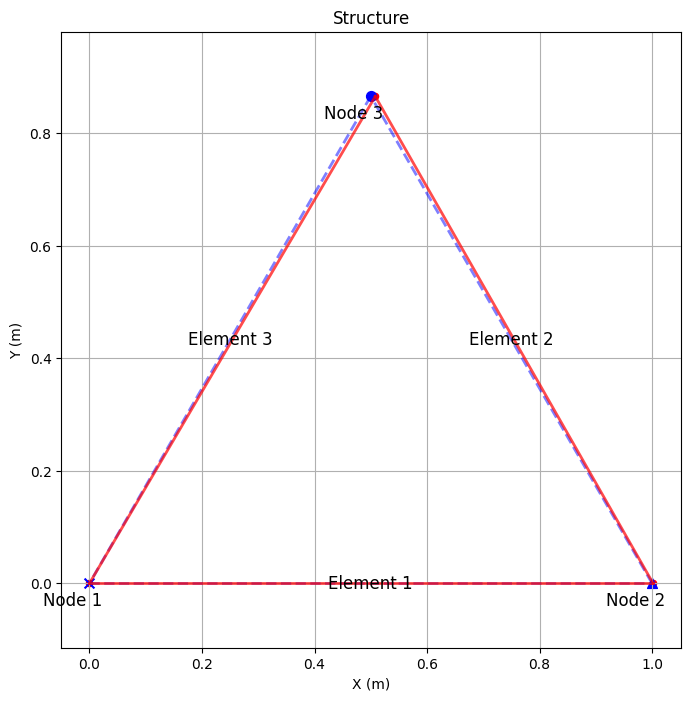

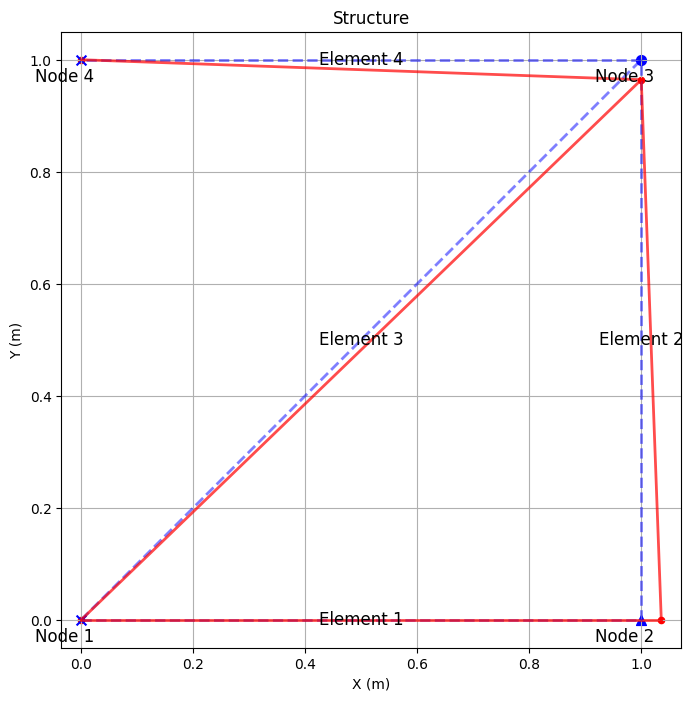

In [199]:
# >>> Test Example <<<

# STEP 1. Define the nodes
node1 = Node(idx=1, origin=True)
node2 = Node(idx=2)
node3 = Node(idx=3)

# STEP 2. Set the forces on the nodes
node3.set_force(500e3, 0.0)  # Force in x direction (N)

# STEP 3. Set the boundary conditions on the nodes
node1.set_BC(True, True)  # Fixed in x and y direction
node2.set_BC(False, True)  # Not fixed
node3.set_BC(False, False)  # Not fixed


# STEP 4. Define the bars
bar1 = Bar(E=70e9, A=0.002, L=1.0, theta=0.0, idx=1, nodes=[node1, node2])
bar2 = Bar(E=70e9, A=0.002, L=1.0, theta=np.deg2rad(120.0), idx=2, nodes=[node2, node3])
bar3 = Bar(E=70e9, A=0.002, L=1.0, theta=np.deg2rad(60.0), idx=3, nodes=[node3, node1])

nodes = [node1, node2, node3]
bars = [bar1, bar2, bar3]

# STEP 5. Solve the system and draw the results
F, K, u = solve(nodes=nodes, elements=bars)
draw(nodes=nodes, elements=bars, u=u)


# >>> Test Example <<<

# STEP 1. Define the nodes
node1 = Node(idx=1, origin=True)
node2 = Node(idx=2)
node3 = Node(idx=3)
node4 = Node(idx=4)

# STEP 2. Set the forces on the nodes
node2.set_force(500e4, 0.0)  # Force in x direction (N)
node3.set_force(0.0, -500e4)  # Force in y direction (N)

# STEP 3. Set the boundary conditions on the nodes
node1.set_BC(True, True)  # Fixed in x and y direction
node2.set_BC(False, True)  # Not fixed
node4.set_BC(True, True)  # Not fixed

# STEP 4. Define the bars
bar1 = Bar(E=70e9, A=0.002, L=1.0, theta=0.0, idx=1, nodes=[node1, node2])
bar2 = Bar(E=70e9, A=0.002, L=1.0, theta=np.deg2rad(90.0), idx=2, nodes=[node2, node3])
bar3 = Bar(
    E=70e1, A=0.002, L=np.sqrt(2.0), theta=np.deg2rad(45.0), idx=3, nodes=[node1, node3]
)
bar4 = Bar(E=70e9, A=0.002, L=1.0, theta=np.deg2rad(180.0), idx=4, nodes=[node3, node4])

nodes = [node1, node2, node3, node4]
bars = [bar1, bar2, bar3, bar4]

# STEP 5. Solve the system and draw the results
F, K, u = solve(nodes=nodes, elements=bars)
draw(nodes=nodes, elements=bars, u=u)

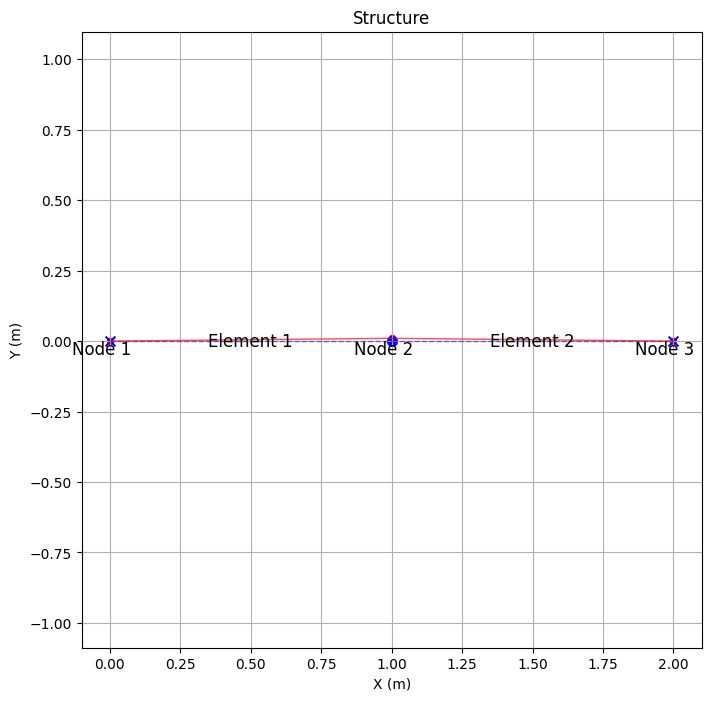

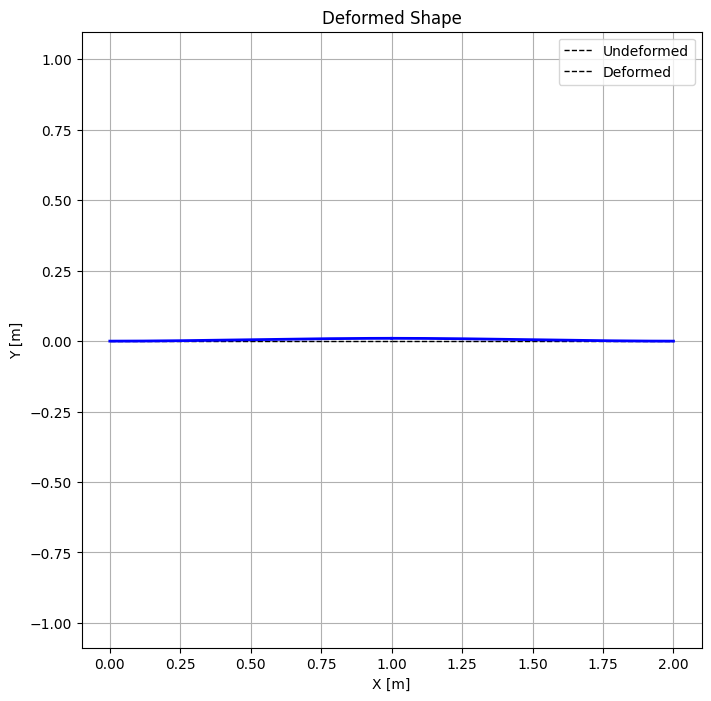

Beam2 shape function at x=0.5: 0.005


In [ ]:
# >>> 05월 20일 제출 과제에 대한 답변 부분입니다. Figure 1은 Shape Function에 의한 보간이 없는 출력입니다 <<<

# STEP 1. Define the nodes
node1 = Node(idx=1, origin=True)
node2 = Node(idx=2)
node3 = Node(idx=3)

# STEP 2. Set the forces on the nodes
node2.set_force(240.0, 0.0)  # Force in x direction (N)

# STEP 3. Set the boundary conditions on the nodes
node1.set_BC(True, True)  # Fixed F, Free M
node3.set_BC(True, True)  # Fixed F, Free M


# STEP 4. Define the bars
beam1 = Beam(E=1000.0, A=0.001, I=1.0, L=1.0, theta=0.0, idx=1, nodes=[node1, node2])
beam2 = Beam(E=1000.0, A=0.001, I=1.0, L=1.0, theta=0.0, idx=2, nodes=[node2, node3])

nodes = [node1, node2, node3]
beams = [beam1, beam2]

# STEP 5. Solve the system and draw the results
F, K, u = solve(nodes=nodes, elements=beams)

draw(nodes=nodes, elements=beams, u=u)
plot_deformed_shape(nodes, beams, u, num_points=1000)

ans = beam2.shape(x=0.5, u_loc=u[2:])
print("Beam2 shape function at x=0.5:", ans)

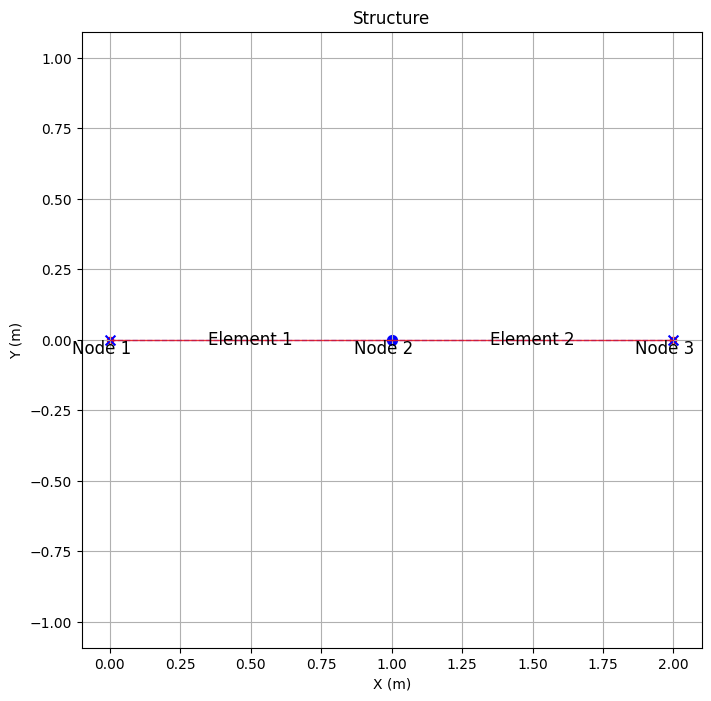

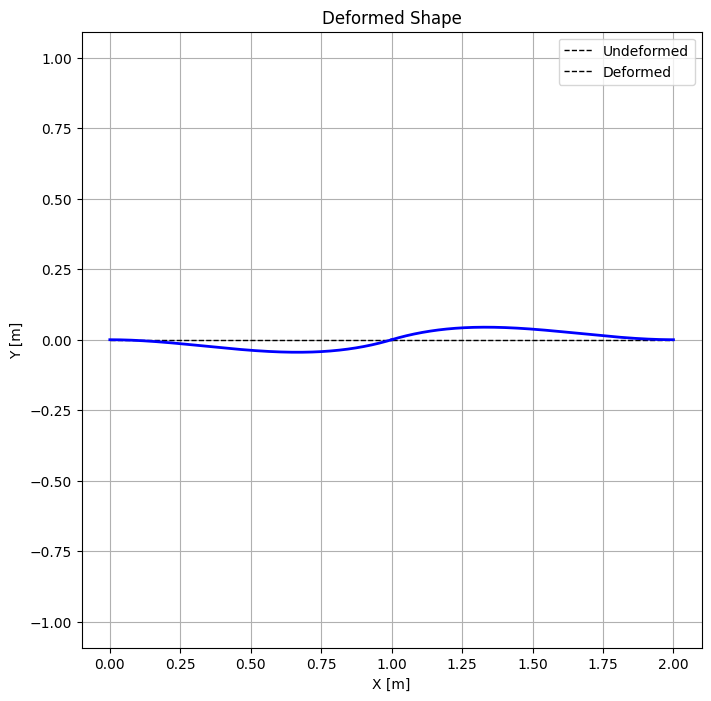

In [201]:
# >>> Test Example <<<

# STEP 1. Define the nodes
node1 = Node(idx=1, origin=True)
node2 = Node(idx=2)
node3 = Node(idx=3)

# STEP 2. Set the forces on the nodes
node2.set_force(0.0, 2.4e3)  # Force in x direction (N)

# STEP 3. Set the boundary conditions on the nodes
node1.set_BC(True, True)  # Fixed F, Free M
node3.set_BC(True, True)  # Fixed F, Free M


# STEP 4. Define the bars
beam1 = Beam(E=1000.0, A=0.001, I=1.0, L=1.0, theta=0.0, idx=1, nodes=[node1, node2])
beam2 = Beam(E=1000.0, A=0.001, I=1.0, L=1.0, theta=0.0, idx=2, nodes=[node2, node3])

nodes = [node1, node2, node3]
beams = [beam1, beam2]

# STEP 5. Solve the system and draw the results
F, K, u = solve(nodes=nodes, elements=beams)

draw(nodes=nodes, elements=beams, u=u)
plot_deformed_shape(nodes, beams, u, num_points=1000)